# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)

## Preliminaries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
##Hyperparameters

Channel = [24,72,216,648]
Kernel_size = [7, 5, 3, 2]
Stride = [1, 1, 1, 1]
Padding = [1, 1, 1, 1]
Dense_features=[2048, 512, 128, 10]
Learning_rate=0.001
dropoutc = 0.01
dropoutl = 0.3
Epochs = 3
Batch_size = 16
beta1 = 0.9
beta2= 0.999
weight_decay=1e-5

Input_width = (32-Kernel_size[0] + 2*Padding[0])/Stride[0] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
print(Input_width)
Input_width = (Input_width - Kernel_size[1] + 2*Padding[1])/Stride[1] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
print(Input_width)
Input_width = (Input_width - Kernel_size[2] + 2*Padding[2])/Stride[2] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
Input_width = (Input_width - Kernel_size[3] + 2*Padding[3])/Stride[3] + 1
print(Input_width)
Input_width = (Input_width-2)/2 + 1
Input_width = int(Input_width)
print(Input_width)


28.0
14.0
12.0
6.0
6.0
4.0
2


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_size,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [4]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([16, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([16, 3, 32, 32])
Number of distinct labels: 10


In [ ]:
# def imshow(img):
#     """ show an image """
#     img = img / 2 + 0.5 # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# images, labels = train_data_iter.__next__()

# # show images
# imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  car plane  bird   dog


## Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # Your code here!

        #[(I – K +2 *P) / S] +1
        self.conv_1 = nn.Conv2d(in_channels=3,
                             out_channels=Channel[0],
                             kernel_size=Kernel_size[0],
                             stride=Stride[0], padding=Padding[0])
        self.bn1 = torch.nn.BatchNorm2d(Channel[0])
 
        #[(I – K) / S] + 1
        self.Maxpool = nn.MaxPool2d(2, 2)

        self.conv_2 = nn.Conv2d(in_channels=Channel[0],
                             out_channels=Channel[1],
                             kernel_size=Kernel_size[1],
                             stride=Stride[1], padding=Padding[1])
        self.bn2 = torch.nn.BatchNorm2d(Channel[1])


        self.conv_3 = nn.Conv2d(Channel[1],
                             out_channels=Channel[2],
                             kernel_size=Kernel_size[2],
                             stride=Stride[1], padding=Padding[2])
        self.bn3 = torch.nn.BatchNorm2d(Channel[2])
        self.conv_4 = nn.Conv2d(in_channels=Channel[2],
                             out_channels=Channel[3],
                             kernel_size=Kernel_size[3],
                             stride=Stride[3], padding=Padding[3])
        self.bn4 = torch.nn.BatchNorm2d(Channel[3]) 
  
       
        self.l1_in_features = Channel[3] * Input_width * Input_width

        self.dropoutc = nn.Dropout2d(p=dropoutc)
        self.dropoutl = nn.Dropout2d(p=dropoutl)

        self.l_1 = nn.Linear(in_features=self.l1_in_features, 
                          out_features=Dense_features[0],
                          bias=True)
        self.l_2 = nn.Linear(in_features=Dense_features[0], 
                            out_features=Dense_features[1],
                            bias=True)
        self.l_3 = nn.Linear(in_features=Dense_features[1], 
                            out_features=Dense_features[2],
                            bias=False)
        self.l_4 = nn.Linear(in_features=Dense_features[2], 
                            out_features=Dense_features[3],
                            bias=False)
        
        self.bnL1 = torch.nn.BatchNorm1d(Dense_features[0])
        self.bnL2 = torch.nn.BatchNorm1d(Dense_features[1])
        self.bnL3 = torch.nn.BatchNorm1d(Dense_features[2])
        self.bnL4 = torch.nn.BatchNorm1d(Dense_features[3])


    def forward(self, x):
        # Your code here!
        x = F.relu(self.conv_1(x))
        x = self.bn1(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_2(x))
        x = self.bn2(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_3(x))
        x = self.bn3(x)
        x = self.Maxpool(x)
        x = F.relu(self.conv_4(x))
        x = self.bn4(x)
        x = self.Maxpool(x)
        x = self.dropoutc(x)
        x = x.view(-1, self.l1_in_features)
        x = F.relu(self.l_1(x))
        x = self.bnL1(x)
        x = F.relu(self.l_2(x))
        x = self.bnL2(x)
        x = F.relu(self.l_3(x))
        x = self.bnL3(x)
        x = F.relu(self.l_4(x))
        x = self.bnL4(x)
        x = self.dropoutl(x)
        return x

    

net = Net(len(used_categories)).cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 24, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(24, 72, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(216, 648, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropoutc): Dropout2d(p=0.01, inplace=False)
  (dropoutl): Dropout2d(p=0.3, inplace=False)
  (l_1): Linear(in_features=2592, out_features=2048, bias=True)
  (l_2): Linear(in_features=2048, out_features=512, bias=True)
  (l_3): Linear

## Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [6]:
import torch.optim as optim

#criterion = None  # Your code here!
#optimizer = None  # Your code here!
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=Learning_rate,betas=(beta1, beta2),  weight_decay = weight_decay)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
num_epoch = Epochs # Your code here!
from sklearn.metrics import accuracy_score

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []


for epoch in range(num_epoch):  # loop over the dataset multiple times


    ### Evaluate training
    running_loss = 0.0

    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

    losses.append(running_loss / Batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i, data in enumerate(trainloader, 0):
                # get the inputs
        inputs, label = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(label.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        preds = preds.cpu()
        train_targs += list(label)
        train_preds += list(preds.data.numpy())



    ### Evaluate validation
    val_preds, val_targs = [], []
    for i, data in enumerate(testloader, 0):
                # get the inputs
        inputs, label = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        output = net(inputs)
        preds = torch.max(output, 1)[1]
        preds = preds.cpu()
        val_preds += list(preds.data.numpy())
        val_targs += list(label)


    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 1 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

print('Finished Training')

C:\Users\Usuario\dtu\env\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


KeyboardInterrupt: 

## Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

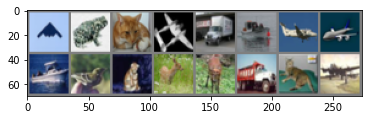

GroundTruth:   plane  frog   cat plane
Predicted:     plane  frog   cat   cat


In [17]:
images, labels = test_data_iter.next()
input, labels = Variable(images.cuda()), Variable(labels.cuda())

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(input).cuda()
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [18]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    input, labels = Variable(images.cuda()), Variable(labels.cuda())
    outputs = net(Variable(input)).cuda()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 10000 test images: 72.73 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [19]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    input, labels = Variable(images.cuda()), Variable(labels.cuda())
    outputs = net(Variable(input)).cuda()

    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    labels=labels.cpu()
    c=c.cpu()
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74.20 %
Accuracy of car   : 65.30 %
Accuracy of bird  : 66.50 %
Accuracy of cat   : 57.70 %
Accuracy of deer  : 75.60 %
Accuracy of dog   : 63.70 %
Accuracy of frog  : 82.00 %
Accuracy of horse : 70.00 %
Accuracy of ship  : 88.80 %
Accuracy of truck : 83.50 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

  Firstly, I run the code with batch = 4, obtaining 50% of accuracy. which was not a good start since it was due to 0% accuracy with cats and 99% accuracy with dogs. I checked the code and I did not notice anything weird.

  I run again the code with batch = 32 and the accuracy increased till 71% with not so much difference between both classes. 

  On a later test, it was introduced a maxpooling layer after the second convolution layer, adding padding=2 instead of 1 in the first layer. The accuracy increased till 73%.

  By adding an additional convolutional layer we reach an accuracy of 73.55%.
  By adding an additional maxpooling layer we reach an accuracy of 75.15%.

  By running the code with a batch size of 64 we  75.15%.
  Again with batch 4 but with better architecture, we achieved 54.4%

  By removing droput, we achieved 75.35%

  After that it was used the same network for the 10 clases obtaining 66.82% accuracy.

  Eventhough, with softmax in the output layer the model should have better performance since is a multiclassification, we are getting better results with Relu activation.

  It was added one convolutional and dense layer more, more channels, and more hidden units in the dense layers obtaining 76.5% with a loss equal to 0.010. This could be a sign of overfitting.

  By implementing more code, to visualize over epochs how the model improve, we checked that there was overfitting, therefore, the batch size was lowered to 16 from 64 in order to generalize the predictions.

  Last test were, introducing momentum and betas of ADAM and we obtained a accuracy of 77% after a few epochs. Therefore it was decided to implement dropout, since the model seemed more stable.

  After several test the boundary of 77% is not surpased. As future work, it would be helpfull to introduce spatial transformer network and increasing overtime dropout.


3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

- Dropout apparently decrease the performance of the model, however, it short the distance between the validation and train accuracy. So I think that at the limit it helps on reaching more optimal weights.


# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)


Verify that σ′(z)=σ(z)(1−σ(z)).

**Answer:**

The sigmoid function is: 

$\sigma(z)=\frac{1}{1+e^{−z}}$.

Then by substuting $\sigma$ in the statement of the question we can obtain that:

 $\sigma '= \frac{1}{1+e^{−z}}·(1-\frac{1}{1+e^{−z}})=\frac{e^{−z}}{(1+e^{−z})^2}$

On the other hand, by transforming the fraction to potency we get:

 $\sigma = (1+e^{−z})^{−1}$. 
 
Doing the derivative of the equation above, we obtain:

$\sigma' = (-1)(-e^{−z})(1+e^{−z})^{−2}=\frac{e^{−z}}{(1+e^{−z})^2}$. 

Finally, we can verify that in both ways, we reach the same function.

